---
author: Zeel B Patel
badges: true
categories: ML
description: Exploring the use of SIRENs for climate modeling
title: Climate Modeling with SIRENs
date: '2023-07-01'
toc: true
---

In [1]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
os.environ["TF_FORCE_GPU_ALLOW_GROWTH"] = "true"

import numpy as np
import xarray as xr
from tqdm.keras import TqdmCallback

import tensorflow as tf
from tensorflow.keras import layers, initializers, activations
from tensorflow.keras.applications.resnet50 import ResNet50
from tensorflow.keras.callbacks import LearningRateScheduler
import tensorflow_addons as tfa

import matplotlib.pyplot as plt

/home/patel_zeel/miniconda3/envs/tensorflow_gpu/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
2023-07-18 05:13:52.439735: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-07-18 05:13:53.232689: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
/home/patel_zeel/miniconda3/envs/tensorflow_gpu/lib/python3.10/site-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a plan

In [2]:
def SIREN(input_dim, output_dim, features, activation_scale, dropout):
    first_init = lambda input_dim: initializers.RandomUniform(-1 / input_dim, 1 / input_dim)
    other_init = lambda input_dim: initializers.RandomUniform(-np.sqrt(6 / input_dim) / activation_scale, np.sqrt(6 / input_dim) / activation_scale)
    model = tf.keras.Sequential()
    model.add(layers.Dense(features[0], input_shape=(input_dim,), kernel_initializer=first_init(input_dim), activation=lambda x: tf.sin(activation_scale*x)))
    for i in range(1, len(features)):
        model.add(layers.Dense(features[i], kernel_initializer=other_init(features[i-1]), activation=lambda x: tf.sin(activation_scale*x)))
        model.add(layers.Dropout(dropout))
    model.add(layers.Dense(output_dim, kernel_initializer=other_init(features[-1]), activation='linear'))
    return model

def MLP(input_dim, output_dim, features, dropout):
    model = tf.keras.Sequential()
    model.add(layers.Dense(features[0], input_shape=(input_dim,), activation=activations.relu))
    for i in range(1, len(features)):
        model.add(layers.Dense(features[i], activation=activations.relu))
        model.add(layers.Dropout(dropout))
    model.add(layers.Dense(output_dim, activation='linear'))
    return model
    
def ResNet():
    resnet = ResNet50(include_top=False, weights=None, input_shape=(64, 32, 1), pooling='avg')
    model = tf.keras.Sequential()
    model.add(resnet)
    model.add(layers.Dense(2048, activation='relu'))
    model.add(layers.Dense(32768, activation='linear'))
    return model

In [3]:
data5 = xr.open_dataset("../../super_res/data/era5_low_res/2m_temperature/2m_temperature_2018_5.625deg.nc")
data1 = xr.open_dataset("../../super_res/data/era5_high_res/2m_temperature/2m_temperature_2018_1.40625deg.nc")

In [4]:
data5

<xarray.Dataset>
Dimensions:  (lon: 64, lat: 32, time: 8760)
Coordinates:
  * lon      (lon) float64 0.0 5.625 11.25 16.88 ... 337.5 343.1 348.8 354.4
  * lat      (lat) float64 -87.19 -81.56 -75.94 -70.31 ... 75.94 81.56 87.19
  * time     (time) datetime64[ns] 2018-01-01 ... 2018-12-31T23:00:00
Data variables:
    t2m      (time, lat, lon) float32 ...
Attributes:
    Conventions:  CF-1.6
    history:      2019-11-06 10:38:21 GMT by grib_to_netcdf-2.14.0: /opt/ecmw...

In [5]:
time_stamp = slice("2018-01", "2018-03")
train_df = data5.sel(time=time_stamp).to_dataframe().reset_index()
test_df = data1.sel(time=time_stamp).to_dataframe().reset_index()

X = np.stack([train_df.lat.values, train_df.lon.values, train_df.time.astype(np.int64) / 10**9], axis=1)
y = train_df[["t2m"]].values
print(f"{X.shape=}, {y.shape=}")

X_test = np.stack([test_df.lat.values, test_df.lon.values, test_df.time.astype(np.int64) / 10**9], axis=1)
y_test = test_df[["t2m"]].values
print(f"{X_test.shape=}, {y_test.shape=}")

# rff = np.random.normal(size=(2, 16)) * 0.01
# X = np.concatenate([np.sin(X @ rff), np.cos(X @ rff)], axis=1)
# print(f"{sin_cos.shape=}")
# X = X @ sin_cos
# X_test = np.concatenate([np.sin(X_test @ rff), np.cos(X_test @ rff)], axis=1)

print(f"{X.shape=}, {X_test.shape=}")

X.shape=(4423680, 3), y.shape=(4423680, 1)
X_test.shape=(70778880, 3), y_test.shape=(70778880, 1)
X.shape=(4423680, 3), X_test.shape=(70778880, 3)


In [6]:
32*64*24*(31+28+31)

4423680

In [7]:
X_max = np.max(X, axis=0, keepdims=True)
X_min = np.min(X, axis=0, keepdims=True)

X_scaled = (X - X_min) / (X_max - X_min)
X_test_scaled = (X_test - X_min) / (X_max - X_min)

# Scaling time
if X.shape[1] == 3:
    X_scaled[:, 2] = X_scaled[:, 2] * 10 - 5
    X_test_scaled[:, 2] = X_test_scaled[:, 2] * 10 - 5

y_min = np.min(y, axis=0, keepdims=True)
y_max = np.max(y, axis=0, keepdims=True)

y_scaled = (y - y_min) / (y_max - y_min)

# y_mean = np.mean(y, axis=0, keepdims=True)
# y_std = np.std(y, axis=0, keepdims=True)

# y_scaled = (y - y_mean) / y_std

In [8]:
model = SIREN(3, 1, [256]*4, 30.0, 0.0)
# model = MLP(3, 1, [256]*4, 0.0)
# model = ResNet()S
# clr = tfa.optimizers.CyclicalLearningRate(initial_learning_rate=1e-3,
#     maximal_learning_rate=1e-2,
#     scale_fn=lambda x: 1/(2.**(x-1)),
#     step_size=2
# )
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-3), loss='mse')

2023-07-18 05:14:34.531498: W tensorflow/core/common_runtime/gpu/gpu_bfc_allocator.cc:47] Overriding orig_value setting because the TF_FORCE_GPU_ALLOW_GROWTH environment variable is set. Original config value was 0.
2023-07-18 05:14:34.531583: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1635] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 78884 MB memory:  -> device: 0, name: NVIDIA A100-SXM4-80GB, pci bus id: 0000:01:00.0, compute capability: 8.0


In [9]:
0.00148

0.00148

In [10]:
callbacks = [TqdmCallback(verbose=1)]
history = model.fit(X_scaled, y_scaled, epochs=1000, batch_size=X_scaled.shape[0], verbose=0, callbacks=callbacks)

  0%|          | 0/1000 [00:00<?, ?epoch/s]2023-07-18 05:14:38.677299: I tensorflow/compiler/xla/stream_executor/cuda/cuda_blas.cc:637] TensorFloat-32 will be used for the matrix multiplication. This will only be logged once.
2023-07-18 05:14:39.357828: I tensorflow/compiler/xla/service/service.cc:169] XLA service 0x7fb81b946130 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-07-18 05:14:39.357901: I tensorflow/compiler/xla/service/service.cc:177]   StreamExecutor device (0): NVIDIA A100-SXM4-80GB, Compute Capability 8.0
2023-07-18 05:14:39.363158: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-07-18 05:14:40.399794: I tensorflow/compiler/xla/stream_executor/cuda/cuda_dnn.cc:424] Loaded cuDNN version 8600
2023-07-18 05:14:40.557542: I ./tensorflow/compiler/jit/device_compiler.h:180] Compiled cluster using XLA!  This line is logg

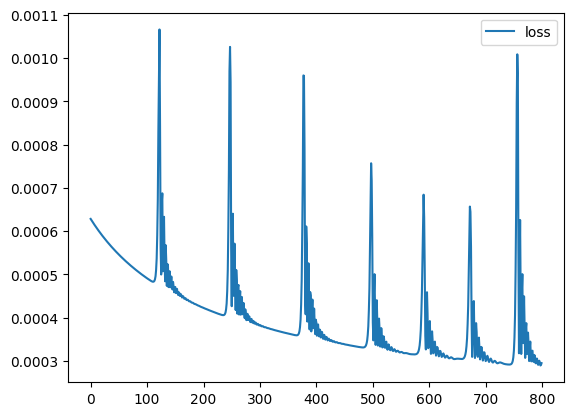

In [11]:
plt.plot(history.history['loss'][200:], label='loss');
# plt.plot(history.history['val_loss'][200:], label='val_loss');
plt.legend();

In [12]:
128*256*24

786432

3456/3456 [==============================] - 5s 1ms/step
(70778880, 1)


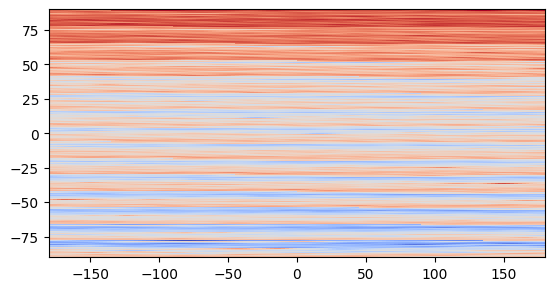

In [13]:
img_index = 0
y_pred = model.predict(X_test_scaled, batch_size=20480) * (y_max - y_min) + y_min
print(y_pred.shape)
plt.imshow(y_pred[img_index*(256*128):(img_index+1)*(256*128)].reshape(256, 128), origin='lower', extent=[-180, 180, -90, 90], cmap='coolwarm', interpolation="none");

In [ ]:
plt.imshow(y.reshape(64, 32), origin='lower', extent=[-180, 180, -90, 90], cmap='coolwarm', interpolation="none");

In [ ]:
diff = y_pred.reshape(256, 128) - y_test.reshape(256, 128)
plt.imshow(diff, origin='lower', extent=[-180, 180, -90, 90], cmap='coolwarm', interpolation="none");
plt.colorbar();
plt.title("Diff")

In [14]:
# rmse = np.sqrt(np.mean(np.abs(X_test[:, 0:1])*(y_pred.ravel() - y_test.ravel())**2))/np.mean(y_test.ravel() * np.abs(X_test[:, 0:1]))
def get_lat_weights(lat):
    lat_weights = np.cos(np.deg2rad(lat))
    lat_weights = lat_weights / lat_weights.mean()
    return lat_weights

lat_weights = get_lat_weights(X_test[:, 0])
print(f"{lat_weights.shape=}")

lat_squared_error = lat_weights * (y_pred.ravel() - y_test.ravel())**2
lat_rmse = np.sqrt(lat_squared_error.mean())
print(f"{lat_rmse=}")
# y_pred.shape, lat_weights.shape

lat_weights.shape=(70778880,)
lat_rmse=2.6118446730600438


In [ ]:
# lat_rmse=3.4826956884024356

In [ ]:
mean_bias = np.mean(y_pred.ravel() - y_test.ravel())
print(f"{mean_bias=}")